In [49]:
'''预测数据集每小时的单车使用量
   评估指标:使用均方根误差评价模型的好坏
   均方根误差越小说明数据的拟合效果越好
   测试值越接近实际值
'''


#1 导入相关的python包

#数据处理
import numpy as np
import pandas as pd
import calendar
from datetime import datetime
from scipy import stats         #概率分布
from scipy.stats import norm    #正态分布

# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns 

# 模型
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split #数据分为训练集和测试集
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# 杂项
import warnings

pd.options.mode.chained_assignment = None  #忽略pandas的警告
warnings.filterwarnings("ignore")          #忽略python的警告
%matplotlib inline                         
#调用matplotlib.pyplot的绘图函数plot()进行绘图的时候，直接在python console里面生成图像

In [50]:
#2读入训练集和测试集
train=pd.read_csv('./input/train.csv',parse_dates=True) # parse_dates将csv中的时间字符串转换成日期格式
test=pd.read_csv('./input/test.csv',parse_dates=True)

In [51]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [52]:
train.head()#日期,季节,节假日,工作日,天气,温度,体感温度,湿度,风速,非注册用户,注册用户,每小时单车使用量(注册+未注册)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [53]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [54]:
train.info()#查看数据类型 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [55]:
#3 日期数据处理及类别特征转换

for df in [train,test]:
    #日期数据处理 object-字符类型
    format = '%Y-%m-%d %H:%M:%S'
    df['date'] = pd.to_datetime(df['datetime'], format=format)   #将datatime转换为 Datetime 类型(时间类型数据)

    df['month'] = df.date.dt.month                               #分别返回系列对象中 Datetime 条目的年,月,星期,小时的 numpy 数组。
    df['day'] = df.date.dt.day
    df['weekday'] = df.date.dt.weekday
    df['hour'] = df.date.dt.hour
    df.drop(['date'], axis=1, inplace=True)

    # 转换部分特征为类别特征
    df['month'] = df.month.apply(lambda x: calendar.month_name[x])    #返回英文月份和星期
    df['weekday'] = df.weekday.apply(lambda x: calendar.day_name[x])

    df["season"] = df.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })        #变量映射取值,为了后期可视化方便
    df["weather"] = df.weather.map({1: "Sunny", 2:"Cloudy", 3:"Light Rain", 4:"Heavy Rain"})

    # 将类别特征强制转换为Category
    category_varlist = ["month", "day", "weekday", "hour", "season", "holiday", "workingday", "weather"]
    for var in category_varlist:
        df[var] = df[var].astype("category")


In [56]:
#缺失值分析：缺失值大的影响预测结果，需要丢弃
print("训练集缺失值数量和：%i" % (train.isnull().sum().sum()))
print("测试集缺失值数量和：%i" % (test.isnull().sum().sum()))

训练集缺失值数量和：0
测试集缺失值数量和：0


Text(0.5, 1.0, 'Box Plot On Count')

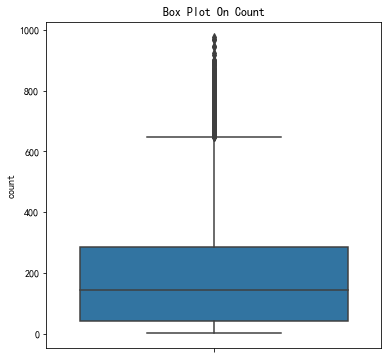

In [57]:
#4异常值处理

#利用箱线图可视化目标变量Count
plt.figure(figsize=(6,6))
sns.boxplot(data=train,y="count")
plt.title("Box Plot On Count")


In [58]:
# 利用3sigma原则去除异常值
print ("去除异常值前的训练集大小：", train.shape)
train = train[abs(train["count"] - train["count"].mean()) <= (3 * train["count"].std())]
print ("去除异常值后的训练集大小：", train.shape)

去除异常值前的训练集大小： (10886, 16)
去除异常值后的训练集大小： (10739, 16)


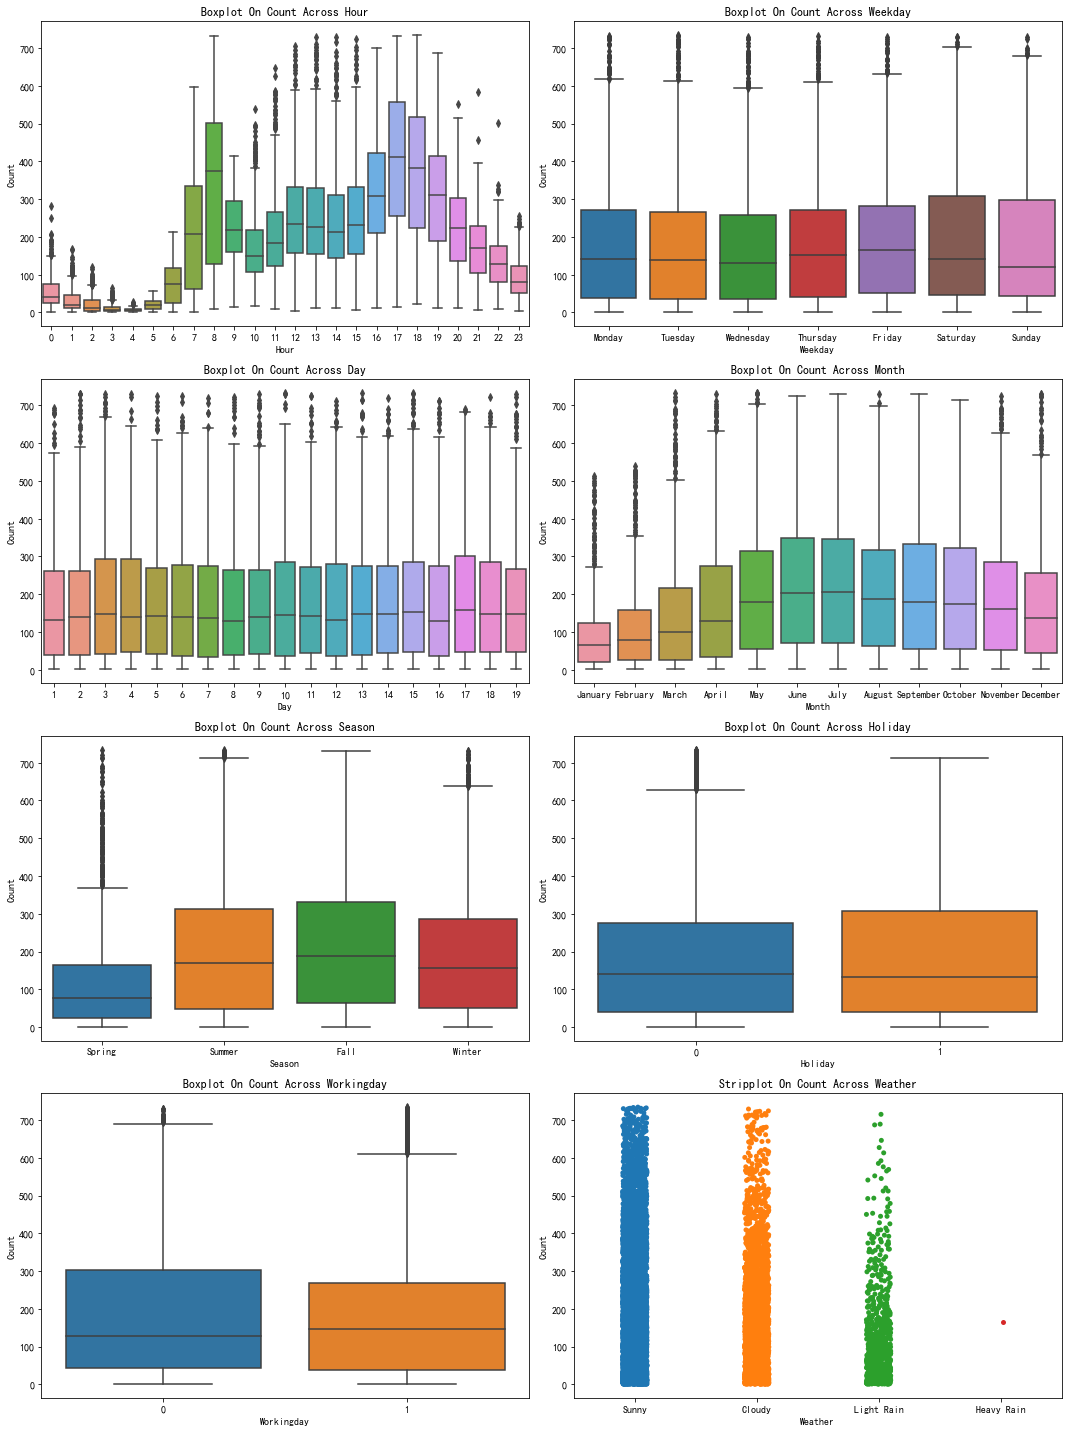

In [59]:
#5 对8个类别特征进行可视化

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
weather_order = ['Sunny', 'Cloudy', 'Light Rain', 'Heavy Rain']

#绘制4行2列8个子图（箱线图）：不同特征下对单车使用量的箱线图
fig, axes = plt.subplots(figsize=(15, 20), nrows=4, ncols=2)
sns.boxplot(data=train, y="count", x="hour", ax=axes[0][0])
sns.boxplot(data=train, y="count", x="weekday", order=weekday_order, ax=axes[0][1])
sns.boxplot(data=train, y="count", x="day", ax=axes[1][0])
sns.boxplot(data=train, y="count", x="month", order=month_order, ax=axes[1][1])
sns.boxplot(data=train, y="count", x="season", order=season_order, ax=axes[2][0])
sns.boxplot(data=train, y="count", x="holiday", ax=axes[2][1])
sns.boxplot(data=train, y="count", x="workingday", ax=axes[3][0])
sns.stripplot(data=train, y="count", x="weather", order=weather_order, ax=axes[3][1])
#子图对象
axes[0][0].set(xlabel='Hour', ylabel='Count', title="Boxplot On Count Across Hour")
axes[0][1].set(xlabel='Weekday', ylabel='Count', title="Boxplot On Count Across Weekday")
axes[1][0].set(xlabel='Day', ylabel='Count', title="Boxplot On Count Across Day")
axes[1][1].set(xlabel='Month', ylabel='Count', title="Boxplot On Count Across Month")
axes[2][0].set(xlabel='Season', ylabel='Count', title="Boxplot On Count Across Season")
axes[2][1].set(xlabel='Holiday', ylabel='Count', title="Boxplot On Count Across Holiday")
axes[3][0].set(xlabel='Workingday', ylabel='Count', title="Boxplot On Count Across Workingday")
axes[3][1].set(xlabel='Weather', ylabel='Count', title="Stripplot On Count Across Weather")

plt.tight_layout()#自动调整子图参数,使之填充整个图像区域

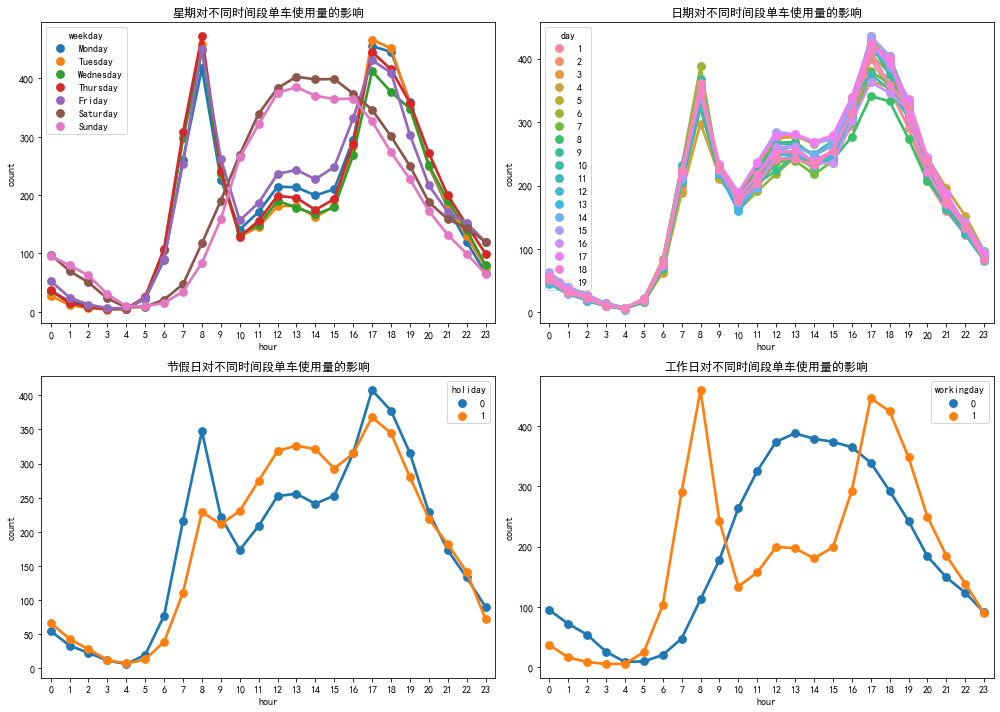

In [60]:
plt.rcParams['font.sans-serif'] = ['SimHei']   #运行配置参数中的字体（font）为黑体（SimHei）
plt.rcParams['axes.unicode_minus'] = False     #运行配置参数总的轴（axes）正常显示正负号（minus）
plt.figure(figsize=(14, 10))
#其次，两字段结合进行可视化分析
plt.subplot(221)                               #2行2列,当前位置为1,第一行的左图
sns.pointplot(x="hour", y="count", hue="weekday", hue_order=weekday_order, ci=None, data=train)#hue是图例，ci为置信区间
plt.title("星期对不同时间段单车使用量的影响")
plt.subplot(222)
sns.pointplot(x="hour", y="count", hue="day", ci=None, data=train)
plt.title("日期对不同时间段单车使用量的影响")
plt.subplot(223)
sns.pointplot(x="hour", y="count", hue="holiday", ci=None, data=train)
plt.title("节假日对不同时间段单车使用量的影响")
plt.subplot(224)
sns.pointplot(x="hour", y="count", hue="workingday", ci=None, data=train)
plt.title("工作日对不同时间段单车使用量的影响")
plt.tight_layout()

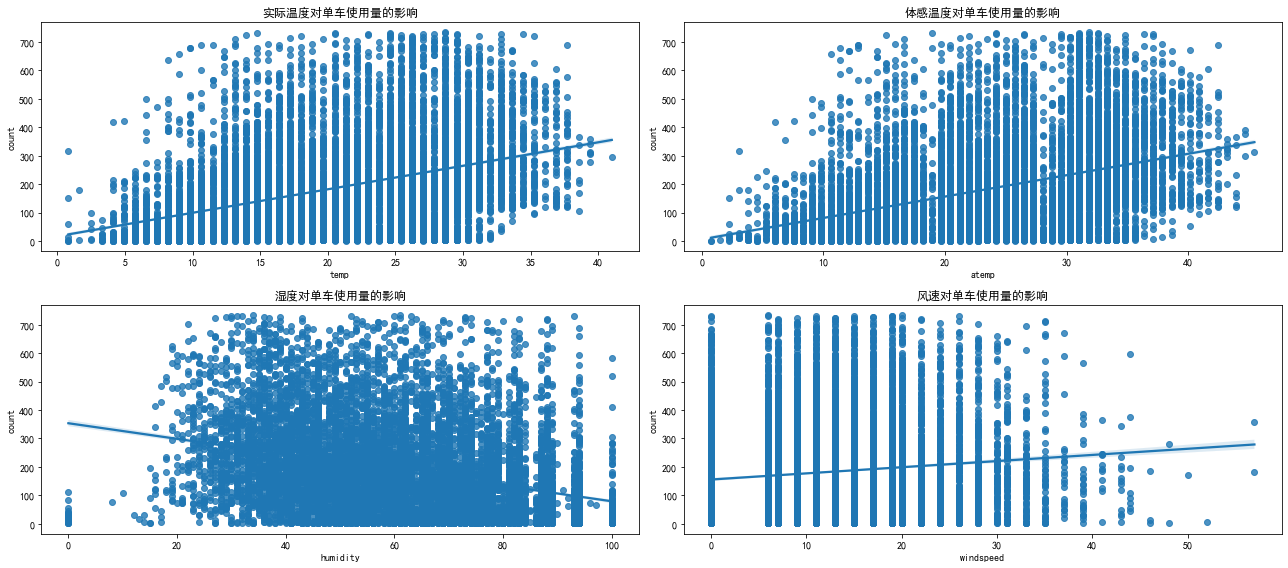

In [61]:
#对数值特征进行可视化 比较两个变量的关系,是否符合线性回归
plt.figure(figsize=(18, 8))
plt.subplot(221)
sns.regplot(x="temp", y="count", data=train)
plt.title("实际温度对单车使用量的影响")
plt.subplot(222)
sns.regplot(x="atemp", y="count", data=train)
plt.title("体感温度对单车使用量的影响")
plt.subplot(223)
sns.regplot(x="humidity", y="count", data=train)
plt.title("湿度对单车使用量的影响")
plt.subplot(224)
sns.regplot(x="windspeed", y="count", data=train)
plt.title("风速对单车使用量的影响")
plt.tight_layout()

In [62]:
melt_df = pd.melt(train[["hour", "casual", "registered", "count"]], id_vars=["hour"], value_vars=["casual", "registered", "count"])#hour标识符列,非注册用户,注册用户,总使用量合并为一列
melt_df

,hour,variable,value
0,0,casual,3
1,1,casual,8
2,2,casual,5
3,3,casual,3
4,4,casual,0
...,...,...,...
32212,19,count,336
32213,20,count,241
32214,21,count,168
32215,22,count,129


In [63]:
melt_group_df = melt_df.groupby(["hour", "variable"])["value"].mean().reset_index()#求每小时段里各个数据的均值(24*3) 以hour分组，算variable的平均值
melt_group_df

,hour,variable,value
0,0,casual,10.312088
1,0,count,55.138462
2,0,registered,44.826374
3,1,casual,6.513216
4,1,count,33.859031
...,...,...,...
67,22,count,133.576754
68,22,registered,110.973684
69,23,casual,15.462719
70,23,count,89.508772


<AxesSubplot:xlabel='hour', ylabel='value'>

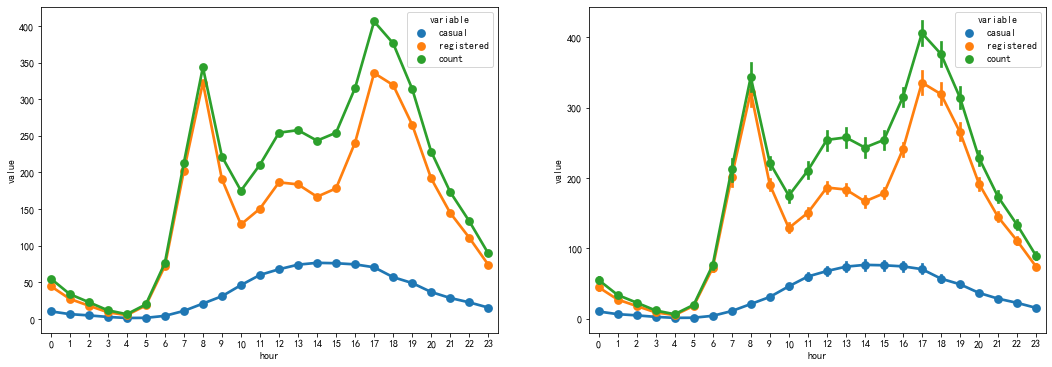

In [64]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
variable_order = ['casual', 'registered', 'count']
sns.pointplot(x="hour", y="value", hue="variable", hue_order=variable_order, data=melt_group_df)
plt.subplot(122)
sns.pointplot(x="hour", y="value", hue="variable", hue_order=variable_order, data=melt_df)

<AxesSubplot:>

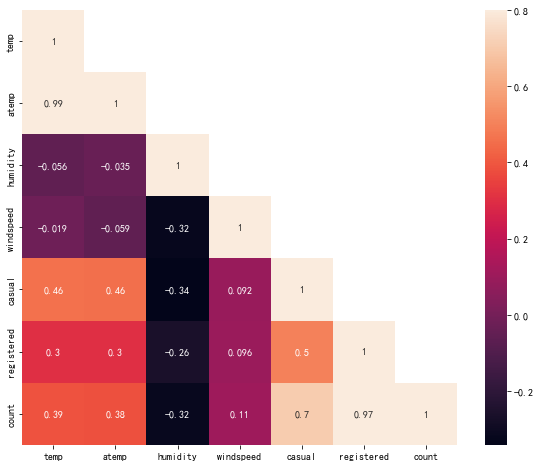

In [65]:
#绘制各个数值特征之间相关的矩阵热图：建模时主要考虑temp，humidity，windspeed

corr_df = train[["temp", "atemp", "humidity", "windspeed", "casual", "registered", "count"]].corr()#计算列的相关性
mask = np.array(corr_df)
mask[np.tril_indices_from(mask)] = False  # mask = np.zeros_like(corr) # mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, mask=mask, vmax=0.8, square=True, annot=True)

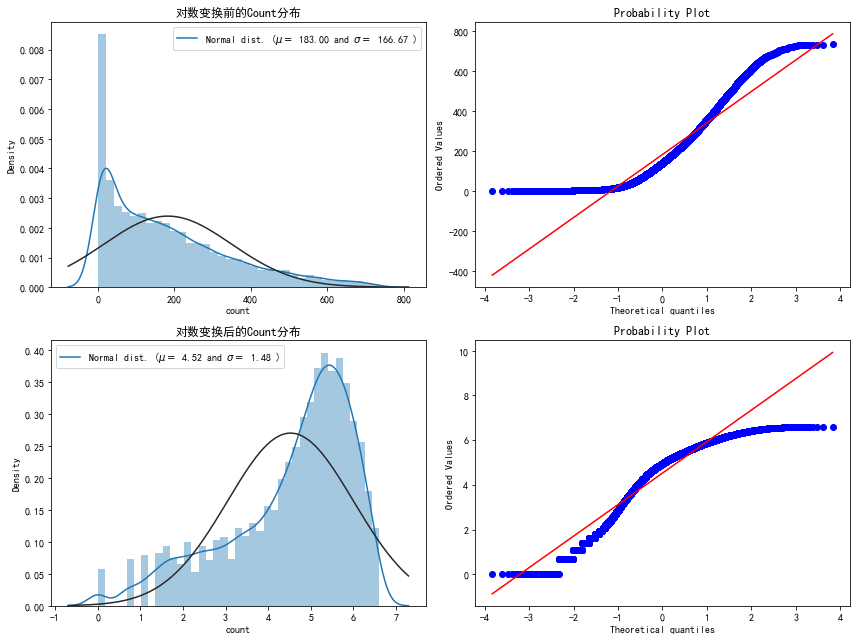

In [66]:
#6 目标变量count的分析

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 9))
(mu, sigma) = norm.fit(train['count'])
sns.distplot(train['count'], fit=norm, ax=ax[0][0])                           #绘制直方图和核密度曲线,并添加正态分布曲线作为参考
ax[0][0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
ax[0][0].set_title("对数变换前的Count分布")
stats.probplot(train['count'], plot=ax[0][1])

train['count'] = np.log(train['count'])
(mu, sigma) = norm.fit(train['count'])
sns.distplot(train['count'], fit=norm, ax=ax[1][0])
ax[1][0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
ax[1][0].set_title("对数变换后的Count分布")
stats.probplot(train['count'], plot=ax[1][1])
plt.tight_layout()

In [67]:
train.windspeed.value_counts().iloc[:10]    #风速为0的值有1297个,采用随机森林模型填充

0.0000     1297
8.9981     1109
11.0014    1037
12.9980    1027
7.0015     1027
15.0013     942
6.0032      866
16.9979     807
19.0012     664
19.9995     486
Name: windspeed, dtype: int64

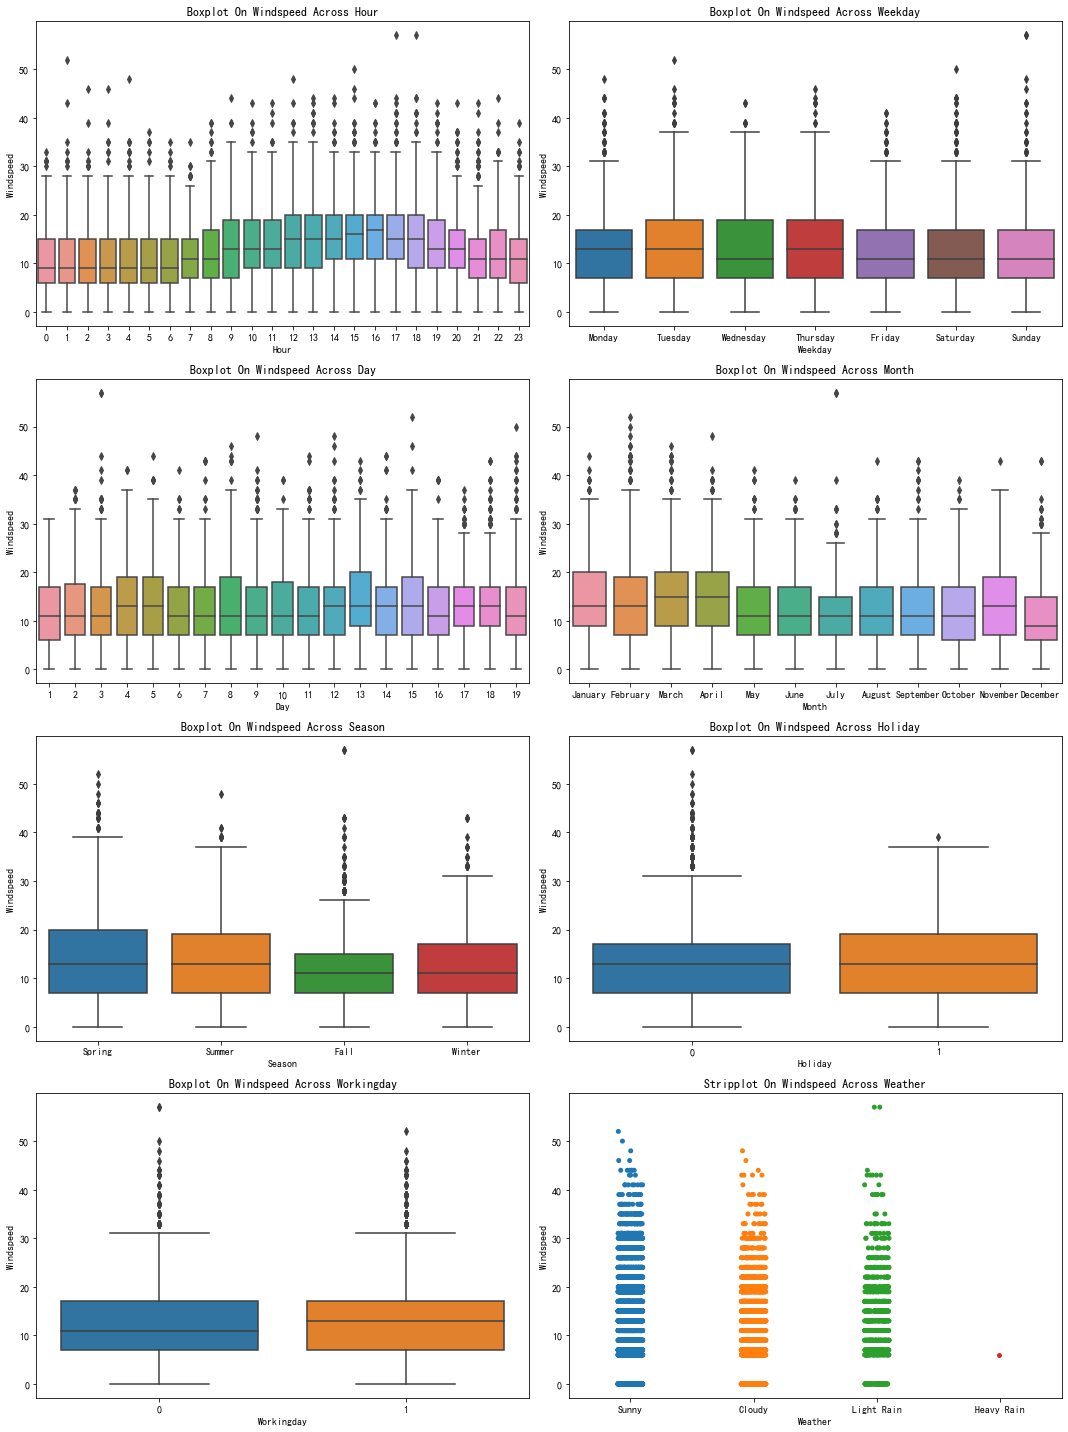

In [68]:
#查看与风速有关的特征
fig, axes = plt.subplots(figsize=(15, 20), nrows=4, ncols=2)
sns.boxplot(data=train, y="windspeed", x="hour", ax=axes[0][0])
sns.boxplot(data=train, y="windspeed", x="weekday", order=weekday_order, ax=axes[0][1])
sns.boxplot(data=train, y="windspeed", x="day", ax=axes[1][0])
sns.boxplot(data=train, y="windspeed", x="month", order=month_order, ax=axes[1][1])
sns.boxplot(data=train, y="windspeed", x="season", order=season_order, ax=axes[2][0])
sns.boxplot(data=train, y="windspeed", x="holiday", ax=axes[2][1])
sns.boxplot(data=train, y="windspeed", x="workingday", ax=axes[3][0])
sns.stripplot(data=train, y="windspeed", x="weather", order=weather_order, ax=axes[3][1])

axes[0][0].set(xlabel='Hour', ylabel='Windspeed', title="Boxplot On Windspeed Across Hour")
axes[0][1].set(xlabel='Weekday', ylabel='Windspeed', title="Boxplot On Windspeed Across Weekday")
axes[1][0].set(xlabel='Day', ylabel='Windspeed', title="Boxplot On Windspeed Across Day")
axes[1][1].set(xlabel='Month', ylabel='Windspeed', title="Boxplot On Windspeed Across Month")
axes[2][0].set(xlabel='Season', ylabel='Windspeed', title="Boxplot On Windspeed Across Season")
axes[2][1].set(xlabel='Holiday', ylabel='Windspeed', title="Boxplot On Windspeed Across Holiday")
axes[3][0].set(xlabel='Workingday', ylabel='Windspeed', title="Boxplot On Windspeed Across Workingday")
axes[3][1].set(xlabel='Weather', ylabel='Windspeed', title="Stripplot On Windspeed Across Weather")
plt.tight_layout()

In [69]:
from sklearn.ensemble import RandomForestRegressor
# 合并数据集
data_train = pd.read_csv("./input/train.csv", parse_dates=True)
data_test = pd.read_csv("./input/test.csv", parse_dates=True)
data = data_train.append(data_test).reset_index(drop=True)    # pd.concat([data_train, data_test]).reset_index(drop=True)

# 日期数据处理
format = '%Y-%m-%d %H:%M:%S'
data['date'] = pd.to_datetime(data['datetime'], format=format)
data['month'] = data.date.dt.month
data['day'] = data.date.dt.day
data['weekday'] = data.date.dt.weekday
data['hour'] = data.date.dt.hour

# 准备数据拟合随机森林模型
windspeed_zero = data[data["windspeed"] == 0]          #风速为0
windspeed_nonzero = data[data["windspeed"] != 0]       #风速不为0
rf_modeling = RandomForestRegressor()
wind_columns = ["hour", "weekday", "day", "month", "season", "workingday", "weather", "temp", "atemp", "humidity"]
rf_modeling.fit(windspeed_nonzero[wind_columns], windspeed_nonzero["windspeed"]) #用风速不为0的数据进行拟合训练

# 用训练好的模型,预测结果.将原始零值替换为预测值
windspeed_pred = rf_modeling.predict(windspeed_zero[wind_columns])
windspeed_zero["windspeed"] = windspeed_pred
data = windspeed_nonzero.append(windspeed_zero).reset_index(drop=True)#合并

In [70]:
# 划分好各类特征
cat_feats = ["hour", "weekday", "day", "month", "season", "holiday", "workingday", "weather"]
num_feats = ["temp", "humidity", "windspeed"]
drop_feats = ["date", "atemp", "casual", "registered"]

# 强制转换类别特征为Category
for var in cat_feats:
    data[var] = data[var].astype("category")   

data.drop(drop_feats, axis=1, inplace=True)

In [71]:
# 分离训练集和测试集 通过count是否为空值分离出原始的数据集和测试集,并按默认的日期进行排序
data_train = data[pd.notnull(data['count'])].sort_values(by=["datetime"]).reset_index(drop=True)
data_test = data[~pd.notnull(data['count'])].sort_values(by=["datetime"]).reset_index(drop=True)

# 目标变量异常值处理与对数变换
data_train = data_train[abs(data_train["count"] - data_train["count"].mean()) <= (3 * data_train["count"].std())]
data_train['count'] = np.log(data_train['count'])
data_train.reset_index(drop=True, inplace=True)

In [72]:
# 指明训练集特征、对应标签及测试集特征
X_train = data_train[cat_feats + num_feats]
y_train = data_train["count"].values 
X_test = data_test[cat_feats + num_feats]
test_id = data_test["datetime"]
del train, test, data_train, data_test

In [73]:
# 标准化数据
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
# 划分数据集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)#划分30%的验证集
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((7517, 11), (3222, 11), (6493, 11), (7517,), (3222,))

In [75]:
# 定义评价函数(均方根误差)
def rmsle(y, y_, convert_exp=True):
    if convert_exp:
        y = np.exp(y),#e次幂
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(value + 1) for value in y]))
    log2 = np.nan_to_num(np.array([np.log(value + 1) for value in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [76]:
# 定义调参函数
def find_best_params(model, params, cv=5, n_jobs=1, X_train=X_train, label=False):
    """
    使用网格搜索交叉验证自动调参GridSearchCV, 返回最佳模型
    """
    rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) # 定义GridSearchCV的评分函数
    grid_cv = GridSearchCV(model, param_grid=params, scoring=rmsle_scorer, n_jobs=n_jobs, cv=cv, verbose=2)
    grid_cv.fit(X_train, y_train)

    # 输出最佳RMSLE得分和最佳参数
    print("最佳的RMSLE得分为: %.3f" % (-grid_cv.best_score_))
    print("最佳的参数为: %s" % (grid_cv.best_params_))
    return grid_cv.best_estimator_
    

In [77]:
# 定义RMSLE结果数据框
global i 
i = 0
def result_save(y_val, y_pred, label):
    result_df = pd.DataFrame({"Model": label, "RMSLE": rmsle(y_val, y_pred)}, index=[i])
    return result_df
    

In [78]:
# 运用模型进行拟合预测
#线性回归
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_val)
print("RMSLE For LinearRegression: %.3f" % (rmsle(y_val, y_pred)))

# 保存RMSLE得分
labels = []
label = "Linear Regression"
labels.append(label)
i = 0
result = result_save(y_val, y_pred, label)
result_df = result
del result
result_df

RMSLE For LinearRegression: 1.041


,Model,RMSLE
0,Linear Regression,1.040708


In [79]:
# 逻辑回归
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train.astype('int'))
y_pred = lr_model.predict(X_val)
print("RMSLE For Logistic Regression: %.3f" % (rmsle(y_val, y_pred)))

# 保存RMSLE得分
label = "Logistic Regression"
labels.append(label)
i += 1
result = result_save(y_val, y_pred, label)
result_df = result_df.append(result)
del result
result_df

RMSLE For Logistic Regression: 1.124


,Model,RMSLE
0,Linear Regression,1.040708
1,Logistic Regression,1.123519


In [80]:
%%time
#K近邻回归(KNeighborsRegressor)
# 运用GridSearchCV调参
params = {
    'n_neighbors': [*range(1, 11)]
}
knn_model = find_best_params(KNeighborsRegressor(), params)
knn_model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n

KNeighborsRegressor(n_neighbors=6)

In [81]:
# 运用调参后的最佳模型进行拟合预测
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_val)
print("RMSLE For KNN: %.3f" % (rmsle(y_val, y_pred)))

# 保存RMSLE得分
label = "KNN"
labels.append(label)
i += 1
result = result_save(y_val, y_pred, label)
result_df = result_df.append(result)
del result
result_df

RMSLE For KNN: 0.850


,Model,RMSLE
0,Linear Regression,1.040708
1,Logistic Regression,1.123519
2,KNN,0.849603


In [82]:
Knn_pred = np.exp(knn_model.predict(X_test))
ensemble_count = Knn_pred.round(0).astype('int')# 将 float 值四舍五入为 int
ensemble_count_df=pd.DataFrame({'ID':test_id,'TARGET':ensemble_count})
ensemble_count_df.to_csv('submission.csv',index=False)
